### HW 5 - Tory Smith

In [312]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint, solve_ivp
from scipy.special import lpmn
import pandas as pd
from datetime import datetime
import sympy as sym
import csv
from filterpy.kalman import ExtendedKalmanFilter

In [313]:
#constants
mu = 398600.4415*1000**3 #m^3/s^2
# R_earth = 6378.137 #km

e_earth = 0.0818191908426215
omega_earth = 7.2921158553E-5 #rad/s
AU = 149597870.7 #km

#initial state
r_ECI = np.array([6990077.798814194, 1617465.311978378, 22679.810569245355]) #m
# r_ECI = np.array([6984.46459301679,	1612.22237259524,	13.0914313353482])*1000 #m
v_ECI = np.array([-1675.13972506056, 7273.72441330686, 252.688512916741])#m/s
# v_ECI = np.array([-1.67664476668291,	7.26144494619245,	0.259889921085112])*1000 #m/s

#station locations
stations = np.array([[-6143584, 1364250, 1033743], 
                    [1907295, 6030810, -817119],
                    [2390310, -5564341 , 1994578]]) #m

#time
JD_UTC = gregorian_to_jd(2018, 2, 1, 5, 0, 0)
leap_sec = 37 #s
x_p = 15.361/1000 #arcsec
y_p = 288.259/1000 #arcsec
del_UT1 = 196.5014 #s


In [314]:
#Rotation Martices
def R1(theta):
    return np.array([[1, 0, 0], \
                     [0, np.cos(theta), np.sin(theta)], \
                     [0, -np.sin(theta), np.cos(theta)]])
def R2(theta):
    return np.array([[np.cos(theta), 0, -np.sin(theta)],\
                    [0, 1, 0], \
                    [np.sin(theta), 0, np.cos(theta)]])
def R3(theta):
    return np.array([[np.cos(theta), np.sin(theta), 0], \
                     [-np.sin(theta), np.cos(theta), 0], \
                    [0, 0, 1]])

In [315]:
def read_nut80():
    # IAU1980 Theory of Nutation model
    dat_file = "nut80.dat"  

    #nutaton model column names
    column_names = ['ki1', 'ki2', 'ki3', 'ki4', 'ki5', 'Aj', 'Bj', 'Cj', 'Dj', 'j']

    #nutation dataframe
    df = pd.read_csv(dat_file, sep="\s+", names=column_names)
    return df

df = read_nut80()

In [316]:
def gregorian_to_jd(year, month, day, hour, minute, second):
    a = int((14 - month)/12)
    y = year + 4800 - a
    m = month + 12*a - 3
    jd = day + int((153*m + 2)/5) + 365*y + int(y/4) - int(y/100) + int(y/400) - 32045
    jd = jd + (hour - 12)/24 + minute/1440 + second/86400
    return jd

In [317]:
def ECI2ECEF(r_ECI, JD_UTC, x_p, y_p, leap_sec, del_UT1):

    '''
    Converts ECI to ECEF using IAU-76/FK5

    Inputs:
    r_ECI: ECI position vector in km
    JD_UTC: Julian Date in UTC
    x_p: x polar motion in arc seconds
    y_p: y polar motion in arc seconds
    leap_sec: leap seconds
    del_UT1: UT1-UTC in seconds

    returns: ECI position vector in km
    '''

    # time constants
    JD2000 = 2451545.0

    #T_UT1
    JD_UT1 = JD_UTC + del_UT1/86400
    T_UT1 = (JD_UT1-JD2000)/36525

    #T_TT
    TAI = JD_UTC + leap_sec/86400
    JD_TT = TAI + 32.184/86400
    T_TT = (JD_TT-JD2000)/36525

    #radians conversions
    arc_sec_to_rad = np.pi/(180*3600)
    deg2rad = np.pi/180

    #Earth Rotation Angles
    x_p = x_p*arc_sec_to_rad
    y_p = x_p*arc_sec_to_rad

    # Polar Motion Matrix
    W = np.matmul(R1(y_p), R2(x_p))
    # r_PEF = np.matmul(W, r_ECEF)

    #Greenwich Mean Sidereal Time
    GMST = 67310.54841 + (876600*3600 + 8640184.812866)*T_UT1 + 0.093104*T_UT1**2 - 6.2E-6*T_UT1**3

    #convert GMST to radians
    GMST = GMST/240*deg2rad

    #anamolies
    r = 360
    Mmoon = (134.96298139 + (1325*r + 198.8673981)*T_TT + 0.0086972*T_TT**2 + 1.78E-5*T_TT**3)
    Mdot = (357.52772333 + (99*r + 359.0503400)*T_TT - 0.0001603*T_TT**2 - 3.3E-6*T_TT**3)
    uMoon = (93.27191028 + (1342*r + 82.0175381)*T_TT - 0.0036825*T_TT**2 + 3.1E-6*T_TT**3)
    Ddot = (297.85036306 + (1236*r + 307.1114800)*T_TT - 0.0019142*T_TT**2 + 5.3E-6*T_TT**3)
    lamMoon = (125.04452222 - (5*r + 134.1362608)*T_TT + 0.0020708*T_TT**2 + 2.2E-6*T_TT**3)
    alpha = np.array([Mmoon, Mdot, uMoon, Ddot, lamMoon])*deg2rad

    # # IAU1980 Theory of Nutation model
    # dat_file = "nut80.dat"  

    # #nutaton model column names
    # column_names = ['ki1', 'ki2', 'ki3', 'ki4', 'ki5', 'Aj', 'Bj', 'Cj', 'Dj', 'j']

    # #nutation dataframe
    # df = pd.read_csv(dat_file, sep="\s+", names=column_names)

    #nutation in lam
    del_psi = np.dot((df['Aj']*10**-4 + df['Bj']*10**-4*T_TT)*arc_sec_to_rad, np.sin(np.dot(df[df.columns[0:5]], alpha)))

    #nutation in obliquity
    del_epsilon = np.dot((df['Cj']*10**-4 + df['Dj']*10**-4*T_TT)*arc_sec_to_rad, np.cos(np.dot(df[df.columns[0:5]], alpha)))

    #mean obliquity of the ecliptic
    epsilon_m = 84381.448 - 46.8150*T_TT - 0.00059*T_TT**2 + 0.001813*T_TT**3

    #EOP corrections
    # ddel_psi = -104.524E-3
    # ddel_epsilon = -8.685E-3

    #conversion to radians
    epsilon_m = epsilon_m*arc_sec_to_rad

    #true obliquity of the ecliptic
    epsilon = epsilon_m + del_epsilon

    #equation of the equinoxes
    Eq_eq = del_psi*np.cos(epsilon_m) + 0.000063*arc_sec_to_rad*np.sin(2*alpha[4]) + 0.00264*arc_sec_to_rad*np.sin(alpha[4])

    #greenwich apparent sidereal time
    GAST = GMST + Eq_eq

    #sidereal rotation matrix
    R = R3(-GAST)
    # r_TOD = np.matmul(R, r_PEF)

    #nutation matrix R1, R3, R1
    N = np.matmul(np.matmul(R1(-epsilon_m), R3(del_psi)), R1(epsilon))
    # r_mod = np.matmul(N, r_TOD)

    #precession angles
    C_a = (2306.2181*T_TT + 0.30188*T_TT**2 + 0.017998*T_TT**3)*arc_sec_to_rad
    theta_a = (2004.3109*T_TT - 0.42665*T_TT**2 - 0.041833*T_TT**3)*arc_sec_to_rad
    z_a = (2306.2181*T_TT + 1.09468*T_TT**2 + 0.018203*T_TT**3)*arc_sec_to_rad

    #precession matrix
    P = np.matmul(np.matmul(R3(C_a), R2(-theta_a)), R3(z_a))

    r_ECEF = np.matmul(np.matmul(np.matmul(np.matmul(W.T, R.T), N.T), P.T), r_ECI)
    return r_ECEF


In [318]:
def ECEF2ECI(r_ECEF, JD_UTC, x_p, y_p, leap_sec, del_UT1):

    '''
    Converts ECEF to ECI using IAU-76/FK5

    Inputs:
    r_ECEF: ECEF position vector in km
    JD_UTC: Julian Date in UTC
    x_p: x polar motion in arc seconds
    y_p: y polar motion in arc seconds
    leap_sec: leap seconds
    del_UT1: UT1-UTC in seconds

    returns: ECI position vector in km
    '''

    # time constants
    JD2000 = 2451545.0
    del_UT1 /= 1000

    #T_UT1
    JD_UT1 = JD_UTC + del_UT1/86400
    T_UT1 = (JD_UT1-JD2000)/36525

    #T_UT1
    TAI = JD_UTC + leap_sec/86400
    JD_TT = TAI + 32.184/86400
    T_TT = (JD_TT-JD2000)/36525

    #radians conversions
    arc_sec_to_rad = np.pi/(180*3600)
    deg2rad = np.pi/180

    #Earth Rotation Angles
    x_p = x_p*arc_sec_to_rad
    y_p = x_p*arc_sec_to_rad

    # Polar Motion Matrix
    W = np.matmul(R1(y_p), R2(x_p))
    # r_PEF = np.matmul(W, r_ECEF)

    #Greenwich Mean Sidereal Time
    GMST = 67310.54841 + (876600*3600 + 8640184.812866)*T_UT1 + 0.093104*T_UT1**2 - 6.2E-6*T_UT1**3

    #convert GMST to radians
    GMST = GMST/240*deg2rad

    #anamolies
    r = 360
    Mmoon = (134.96298139 + (1325*r + 198.8673981)*T_TT + 0.0086972*T_TT**2 + 1.78E-5*T_TT**3)
    Mdot = (357.52772333 + (99*r + 359.0503400)*T_TT - 0.0001603*T_TT**2 - 3.3E-6*T_TT**3)
    uMoon = (93.27191028 + (1342*r + 82.0175381)*T_TT - 0.0036825*T_TT**2 + 3.1E-6*T_TT**3)
    Ddot = (297.85036306 + (1236*r + 307.1114800)*T_TT - 0.0019142*T_TT**2 + 5.3E-6*T_TT**3)
    lamMoon = (125.04452222 - (5*r + 134.1362608)*T_TT + 0.0020708*T_TT**2 + 2.2E-6*T_TT**3)
    alpha = np.array([Mmoon, Mdot, uMoon, Ddot, lamMoon])*deg2rad

    # # IAU1980 Theory of Nutation model
    # dat_file = "nut80.dat"  

    # #nutaton model column names
    # column_names = ['ki1', 'ki2', 'ki3', 'ki4', 'ki5', 'Aj', 'Bj', 'Cj', 'Dj', 'j']

    # #nutation dataframe
    # df = pd.read_csv(dat_file, sep="\s+", names=column_names)

    #nutation in lam
    del_psi = np.dot((df['Aj']*10**-4 + df['Bj']*10**-4*T_TT)*arc_sec_to_rad, np.sin(np.dot(df[df.columns[0:5]], alpha)))

    #nutation in obliquity
    del_epsilon = np.dot((df['Cj']*10**-4 + df['Dj']*10**-4*T_TT)*arc_sec_to_rad, np.cos(np.dot(df[df.columns[0:5]], alpha)))

    #mean obliquity of the ecliptic
    epsilon_m = 84381.448 - 46.8150*T_TT - 0.00059*T_TT**2 + 0.001813*T_TT**3

    #EOP corrections
    # ddel_psi = -104.524E-3
    # ddel_epsilon = -8.685E-3

    #conversion to radians
    epsilon_m = epsilon_m*arc_sec_to_rad

    #true obliquity of the ecliptic
    epsilon = epsilon_m + del_epsilon

    #equation of the equinoxes
    Eq_eq = del_psi*np.cos(epsilon_m) + 0.000063*arc_sec_to_rad*np.sin(2*alpha[4]) + 0.00264*arc_sec_to_rad*np.sin(alpha[4])

    #greenwich apparent sidereal time
    GAST = GMST + Eq_eq

    #sidereal rotation matrix
    R = R3(-GAST)
    # r_TOD = np.matmul(R, r_PEF)

    #nutation matrix R1, R3, R1
    N = np.matmul(np.matmul(R1(-epsilon_m), R3(del_psi)), R1(epsilon))
    # r_mod = np.matmul(N, r_TOD)

    #precession angles
    C_a = (2306.2181*T_TT + 0.30188*T_TT**2 + 0.017998*T_TT**3)*arc_sec_to_rad
    theta_a = (2004.3109*T_TT - 0.42665*T_TT**2 - 0.041833*T_TT**3)*arc_sec_to_rad
    z_a = (2306.2181*T_TT + 1.09468*T_TT**2 + 0.018203*T_TT**3)*arc_sec_to_rad

    #precession matrix
    P = np.matmul(np.matmul(R3(C_a), R2(-theta_a)), R3(z_a))

    r_ECI = np.matmul(np.matmul(np.matmul(np.matmul(P, N), R), W), r_ECEF)
    return r_ECI

r_ECEF = np.array([-28738.3218400000, -30844.0723200000, -6.71800000000000])



In [319]:
def sun_position_vector(JD_UTC, del_UT1, leap_sec):
    
    # Constants
    deg2rad = np.pi / 180.0
    au = 149597870.691*1000 # Astronomical unit [m]
    arc_sec_to_rad = np.pi/(180*3600)
    # Time variables
    
    JD2000 = 2451545.0

    del_UT1 /=1000

    #T_UT1
    JD_UT1 = JD_UTC + del_UT1/86400
    T_UT1 = (JD_UT1-JD2000)/36525

    #T_TT
    TAI = JD_UTC + leap_sec/86400
    JD_TT = TAI + 32.184/86400
    T_TT = (JD_TT-JD2000)/36525

    # Mean lam of the Sun
    l = (280.460 + 36000.771285 * T_UT1) %360

    # Mean anomaly of the Sun
    M = (357.528 + 35999.050957 * T_UT1) %360

    # Ecliptic lam of the Sun
    lambda_sun = l + 1.915 * np.sin(M * deg2rad) + 0.020 * np.sin(2 * M * deg2rad)

    # Obliquity of the ecliptic
    epsilon = 23.439291 - 0.01461 * T_UT1

    #magnitude of the sun
    R = 1.00014 - 0.01671 * np.cos(M * deg2rad) - 0.00014 * np.cos(2 * M * deg2rad)

    #sun position vector in ecliptic coordinates
    r_ecliptic = np.array([R * np.cos(lambda_sun * deg2rad), 
                           R * np.cos(epsilon * deg2rad) * np.sin(lambda_sun * deg2rad), 
                           R * np.sin(epsilon * deg2rad) * np.sin(lambda_sun * deg2rad)])
    
    #rotation from TOD to ECI

    #anamolies
    r = 360
    Mmoon = (134.96298139 + (1325*r + 198.8673981)*T_TT + 0.0086972*T_TT**2 + 1.78E-5*T_TT**3)
    Mdot = (357.52772333 + (99*r + 359.0503400)*T_TT - 0.0001603*T_TT**2 - 3.3E-6*T_TT**3)
    uMoon = (93.27191028 + (1342*r + 82.0175381)*T_TT - 0.0036825*T_TT**2 + 3.1E-6*T_TT**3)
    Ddot = (297.85036306 + (1236*r + 307.1114800)*T_TT - 0.0019142*T_TT**2 + 5.3E-6*T_TT**3)
    lamMoon = (125.04452222 - (5*r + 134.1362608)*T_TT + 0.0020708*T_TT**2 + 2.2E-6*T_TT**3)
    alpha = np.array([Mmoon, Mdot, uMoon, Ddot, lamMoon])*deg2rad


    #nutation in lam
    del_psi = np.dot((df['Aj']*10**-4 + df['Bj']*10**-4*T_TT)*arc_sec_to_rad, np.sin(np.dot(df[df.columns[0:5]], alpha)))

    #nutation in obliquity
    del_epsilon = np.dot((df['Cj']*10**-4 + df['Dj']*10**-4*T_TT)*arc_sec_to_rad, np.cos(np.dot(df[df.columns[0:5]], alpha)))

    #mean obliquity of the ecliptic
    epsilon_m = 84381.448 - 46.8150*T_TT - 0.00059*T_TT**2 + 0.001813*T_TT**3

    #conversion to radians
    epsilon_m = epsilon_m*arc_sec_to_rad

    #true obliquity of the ecliptic
    epsilon = epsilon_m + del_epsilon

    #nutation matrix R1, R3, R1
    N = np.matmul(np.matmul(R1(-epsilon_m), R3(del_psi)), R1(epsilon))

    #precession angles
    C_a = (2306.2181*T_TT + 0.30188*T_TT**2 + 0.017998*T_TT**3)*arc_sec_to_rad
    theta_a = (2004.3109*T_TT - 0.42665*T_TT**2 - 0.041833*T_TT**3)*arc_sec_to_rad
    z_a = (2306.2181*T_TT + 1.09468*T_TT**2 + 0.018203*T_TT**3)*arc_sec_to_rad

    #precession matrix
    P = np.matmul(np.matmul(R3(C_a), R2(-theta_a)), R3(z_a))

    #sun position vector in ECI
    r_ECI = np.matmul(P, np.matmul(N, r_ecliptic))*au

    return r_ECI


In [320]:
def moon_position_vector(JD_UTC, del_UT1, leap_sec):
    # Constants
    deg2rad = np.pi / 180.0
    # Time variables
    
    JD2000 = 2451545.0

    #T_UT1
    JD_UT1 = JD_UTC + del_UT1/86400
    T_UT1 = (JD_UT1-JD2000)/36525

    #T_TT
    TAI = JD_UTC + leap_sec/86400
  
    JD_TT = TAI + 32.184/86400
    T_TT = (JD_TT-JD2000)/36525
  
    # Mean lam of the Moon
    l = (218.32 + 481267.8813*T_TT + 6.29*np.sin((134.9 + 477198.85*T_TT)*deg2rad) \
        - 1.27*np.sin((259.2 - 413335.38*T_TT)*deg2rad) + 0.66*np.sin((235.7 + 890534.23*T_TT)*deg2rad) \
        + 0.21*np.sin((269.9 + 954397.70*T_TT)*deg2rad) - 0.19*np.sin((357.5 + 35999.05*T_TT)*deg2rad) \
        - 0.11*np.sin((186.6 + 966404.05*T_TT)*deg2rad)) % 360
   
    #ecliptic lattitude of the Moon
    phi = (5.13*np.sin((93.3 + 483202.03*T_TT)*deg2rad) + 0.28*np.sin((228.2 + 960400.87*T_TT)*deg2rad) \
        - 0.28*np.sin((318.3 + 6003.18*T_TT)*deg2rad) - 0.17*np.sin((217.6 - 407332.20*T_TT)*deg2rad)) %360
  
    # Horizontal parallax of the Moon
    O = (0.9508 + 0.0518*np.cos((134.9 + 477198.85*T_TT)*deg2rad) \
        + 0.0095*np.cos((259.2 - 413335.38*T_TT)*deg2rad) + 0.0078*np.cos((235.7 + 890534.23*T_TT)*deg2rad) \
        + 0.0028*np.cos((269.9 + 954397.70*T_TT)*deg2rad)) % 360
    
    #oblquity of the ecliptic
    epsilon = (23.439291 - 0.0130042*T_TT - 1.64E-7*T_TT**2 + 5.04E-7*T_TT**3) % 360
    #magnitude of the vector from the Earth to the Moon
    R_earth = 6378.1363*1000 #m
    r_moon = R_earth/np.sin(O*deg2rad)
    #moon position vector in ecliptic coordinates
    r_ecliptic = np.array([r_moon*np.cos(phi*deg2rad)*np.cos(l*deg2rad), \
                           r_moon*(np.cos(epsilon*deg2rad)*np.cos(phi*deg2rad)*np.sin(l*deg2rad) - np.sin(epsilon*deg2rad)*np.sin(phi*deg2rad)), \
                            r_moon*(np.sin(epsilon*deg2rad)*np.cos(phi*deg2rad)*np.sin(l*deg2rad) + np.cos(epsilon*deg2rad)*np.sin(phi*deg2rad))])
   
    #rotation from TOD to ECI
    arc_sec_to_rad = np.pi/(180*3600)
    #anamolies
    r = 360
    Mmoon = (134.96298139 + (1325*r + 198.8673981)*T_TT + 0.0086972*T_TT**2 + 1.78E-5*T_TT**3)
    Mdot = (357.52772333 + (99*r + 359.0503400)*T_TT - 0.0001603*T_TT**2 - 3.3E-6*T_TT**3)
    uMoon = (93.27191028 + (1342*r + 82.0175381)*T_TT - 0.0036825*T_TT**2 + 3.1E-6*T_TT**3)
    Ddot = (297.85036306 + (1236*r + 307.1114800)*T_TT - 0.0019142*T_TT**2 + 5.3E-6*T_TT**3)
    lamMoon = (125.04452222 - (5*r + 134.1362608)*T_TT + 0.0020708*T_TT**2 + 2.2E-6*T_TT**3)
    alpha = np.array([Mmoon, Mdot, uMoon, Ddot, lamMoon])*deg2rad

    #nutation in lam
    del_psi = np.dot((df['Aj']*10**-4 + df['Bj']*10**-4*T_TT)*arc_sec_to_rad, np.sin(np.dot(df[df.columns[0:5]], alpha)))

    #nutation in obliquity
    del_epsilon = np.dot((df['Cj']*10**-4 + df['Dj']*10**-4*T_TT)*arc_sec_to_rad, np.cos(np.dot(df[df.columns[0:5]], alpha)))

    #mean obliquity of the ecliptic
    epsilon_m = 84381.448 - 46.8150*T_TT - 0.00059*T_TT**2 + 0.001813*T_TT**3

    #conversion to radians
    epsilon_m = epsilon_m*arc_sec_to_rad

    #true obliquity of the ecliptic
    epsilon = epsilon_m + del_epsilon

    #nutation matrix R1, R3, R1
    N = np.matmul(np.matmul(R1(-epsilon_m), R3(del_psi)), R1(epsilon))

    #precession angles
    C_a = (2306.2181*T_TT + 0.30188*T_TT**2 + 0.017998*T_TT**3)*arc_sec_to_rad
    theta_a = (2004.3109*T_TT - 0.42665*T_TT**2 - 0.041833*T_TT**3)*arc_sec_to_rad
    z_a = (2306.2181*T_TT + 1.09468*T_TT**2 + 0.018203*T_TT**3)*arc_sec_to_rad

    #precession matrix
    P = np.matmul(np.matmul(R3(C_a), R2(-theta_a)), R3(z_a))

    #sun position vector in ECI
    r_ECI = np.matmul(P, np.matmul(N, r_ecliptic))


    return r_ECI


In [321]:
def equations_of_motion_A(drag=False, gravity=False, solar=False, third_body=False):

    #base equation of motion
    x = sym.Symbol('x')
    y = sym.Symbol('y')
    z = sym.Symbol('z')
    mu = 398600.4418*1000**3 #m^3/s^2
    r = (x**2 + y**2 + z**2)**(1/2)
    
    #no perturbations
    F_x = -mu*x/r**3
    F_y = -mu*y/r**3
    F_z = -mu*z/r**3
    
    #with gravity
    if gravity:
        R_earth = 6378.1363*1000 #[m]
        J_2 = 0.00108248
        phi = z/r
        F_x = sym.diff(mu/r*(1-J_2*(R_earth/r)**2*(3/2*phi**2-1/2)), x)
        F_y = sym.diff(mu/r*(1-J_2*(R_earth/r)**2*(3/2*phi**2-1/2)), y)
        F_z = sym.diff(mu/r*(1-J_2*(R_earth/r)**2*(3/2*phi**2-1/2)), z)

    
    #with atmospheric drag
    if drag:

        A_Cross= sym.Symbol('A_Cross')
        x_dot = sym.Symbol('x_dot')
        y_dot = sym.Symbol('y_dot')
        z_dot = sym.Symbol('z_dot')
        C_D = sym.Symbol('C_D')

        R_earth = 6378.1363*1000 #[m]
        m = 2000 #[kg]
        theta_dot = 7.292115146706979E-5 #[rad/s]
        rho_0 = 3.614E-13 #[kg/m^3]
        H = 88667.0 #[m]
        r0 = (700000.0 + R_earth) #[m]

        rho_A = rho_0*sym.exp(-(r-r0)/H)
        
        V_A_bar = sym.Matrix([x_dot+theta_dot*y, y_dot-theta_dot*x, z_dot])
        V_A = sym.sqrt((x_dot + theta_dot*y)**2 + (y_dot-theta_dot*x)**2 + z_dot**2)
        
        r_ddot = -1/2*C_D*A_Cross/m*rho_A*V_A*V_A_bar
        F_x += r_ddot[0]
        F_y += r_ddot[1]
        F_z += r_ddot[2]

    #with solar radiation pressure
    if solar:
        A_Cross_Sol = sym.Symbol('A_Cross_Sol')
        r_sun = sym.MatrixSymbol('r_sun', 1, 3)

        AU = 149597870700 #[m]
        m = 2000 #kg
        c = 299792458 #m/s
        d = ((r_sun[0]+x)**2 + (r_sun[1]+y)**2 + (r_sun[2]+z)**2)**(1/2)
        phi = 1367 #W/m^2
        C1 = phi/c 
        C_s = 0.04
        C_d = 0.04
        v = 1/3*C_d
        mu = 1/2*C_s
        theta = 0
        
        B = 2*v*sym.cos(theta)+4*mu*sym.cos(theta)**2
        F_x += -C1/(d/AU)**2*(B + (1-mu)*sym.cos(theta))*A_Cross_Sol/m*(r_sun[0]+x)/d
        F_y += -C1/(d/AU)**2*(B + (1-mu)*sym.cos(theta))*A_Cross_Sol/m*(r_sun[1]+y)/d
        F_z += -C1/(d/AU)**2*(B + (1-mu)*sym.cos(theta))*A_Cross_Sol/m*(r_sun[2]+z)/d

    #with thrird body perturbations
    if third_body:
        mu_sun = 132712440018*1000**3 #[m^3/s^2]
        mu_moon = 4902.800066*1000**3 #[m^3/s^2]
        
        r_sun = sym.MatrixSymbol('r_sun', 1, 3)
        r_moon = sym.MatrixSymbol('r_moon', 1, 3)
        r_sun_mag = (r_sun[0]**2 + r_sun[1]**2 + r_sun[2]**2)**(1/2)
        r_moon_mag = (r_moon[0]**2 + r_moon[1]**2 + r_moon[2]**2)**(1/2)
        
        del_sun_mag = ((r_sun[0]+x)**2 + (r_sun[1]+y)**2 + (r_sun[2]+z)**2)**(1/2)
        del_moon_mag = ((r_moon[0]+x)**2 + (r_moon[1]+y)**2 + (r_moon[2]+z)**2)**(1/2)
        F_x += mu_sun*((r_sun[0]+x)/(del_sun_mag)**3 - r_sun[0]/r_sun_mag**3) + mu_moon*((r_moon[0]+x)/(del_moon_mag**3) - r_moon[0]/r_moon_mag**3)
        F_y += mu_sun*((r_sun[1]+y)/(del_sun_mag)**3 - r_sun[1]/r_sun_mag**3) + mu_moon*((r_moon[1]+y)/(del_moon_mag**3) - r_moon[1]/r_moon_mag**3)
        F_z += mu_sun*((r_sun[2]+z)/(del_sun_mag)**3 - r_sun[2]/r_sun_mag**3) + mu_moon*((r_moon[2]+z)/(del_moon_mag**3) - r_moon[2]/r_moon_mag**3)

    return F_x, F_y, F_z

**1. Derive the An×n and  ̃Hm×n matrices for the linearized system and implement the partials in your
computer language of choice. Compare to the numeric solutions
online at t0.**

In [322]:
#symbolicly solve for the A matrix

#symbolic variables
x = sym.Symbol('x')
y = sym.Symbol('y')
z = sym.Symbol('z')
x_dot = sym.Symbol('x_dot')
y_dot = sym.Symbol('y_dot')
z_dot = sym.Symbol('z_dot')
C_D = sym.Symbol('C_D')
r = sym.sqrt(x**2 + y**2 + z**2)

#gravitational parameters (acceleration 1E-3 - 1E-5)

#drag parameters (acceleration 1E-11 - 1E-12)
A_Cross= sym.Symbol('A_Cross')

#solar radiation pressure parameters (order of magnitude for acceleration 1e-13)
A_Cross_Sol = sym.Symbol('A_Cross_Sol')

#third body perturbation parameters (acceleration is 1e-10 km/s^2)
r_sun = sym.MatrixSymbol('r_sun', 1, 3)
r_moon = sym.MatrixSymbol('r_moon', 1, 3)

#perturbation switches
gravity = True
drag = True
solar = True
third_body = True

#F functions
F1 = x_dot
F2 = y_dot
F3 = z_dot
F4, F5, F6 = equations_of_motion_A(drag, gravity, solar, third_body)
F7 = 0

#A matrix
A = [[sym.diff(F1, x), sym.diff(F1, y), sym.diff(F1, z), sym.diff(F1, x_dot), sym.diff(F1, y_dot), sym.diff(F1, z_dot), sym.diff(F1, C_D)],
     [sym.diff(F2, x), sym.diff(F2, y), sym.diff(F2, z), sym.diff(F2, x_dot), sym.diff(F2, y_dot), sym.diff(F2, z_dot), sym.diff(F2, C_D)],
     [sym.diff(F3, x), sym.diff(F3, y), sym.diff(F3, z), sym.diff(F3, x_dot), sym.diff(F3, y_dot), sym.diff(F3, z_dot), sym.diff(F3, C_D)],
     [sym.diff(F4, x), sym.diff(F4, y), sym.diff(F4, z), sym.diff(F4, x_dot), sym.diff(F4, y_dot), sym.diff(F4, z_dot), sym.diff(F4, C_D)],
     [sym.diff(F5, x), sym.diff(F5, y), sym.diff(F5, z), sym.diff(F5, x_dot), sym.diff(F5, y_dot), sym.diff(F5, z_dot), sym.diff(F5, C_D)],
     [sym.diff(F6, x), sym.diff(F6, y), sym.diff(F6, z), sym.diff(F6, x_dot), sym.diff(F6, y_dot), sym.diff(F6, z_dot), sym.diff(F6, C_D)],
     [sym.diff(F7, x), sym.diff(F7, y), sym.diff(F7, z), sym.diff(F7, x_dot), sym.diff(F7, y_dot), sym.diff(F7, z_dot), sym.diff(F7, C_D)]]


if gravity and drag and solar and third_body:
     A = sym.lambdify([x, y, z, x_dot, y_dot, z_dot, C_D, A_Cross, A_Cross_Sol, r_sun, r_moon], A)
     
elif gravity:
     A = sym.lambdify([x, y, z], A)

elif drag:
     A = sym.lambdify([x, y, z, x_dot, y_dot, z_dot, C_D, A_Cross], A)

elif solar:
     A = sym.lambdify([x, y, z, A_Cross_Sol, d, m, theta], A)

elif third_body:
     A = sym.lambdify([x, y, z, r_sun, r_moon], A)

else:
     A = sym.lambdify([x, y, z], A)


**A Matrix: Compute the relative difference for each non-zero element**

A Matrix Relative Difference 
 [[  0.0000060979293149   0.0000040595890766   0.0014015234593032
    0.059999999999755    0.0599999999997543   0.059999999999754
  999.0000000002617   ]
 [  0.0000040763168061   0.00000152709273     0.0014794654814895
    0.0599999999997543   0.0599999999997556   0.0599999999997545
  999.0000000002607   ]
 [  0.0014015652962763   0.0014794910826966   0.0000099614463589
    0.059999999999754    0.0599999999997545   0.0599999999997548
  999.000000000263    ]]


Text(0, 0.5, 'Number of exponents')

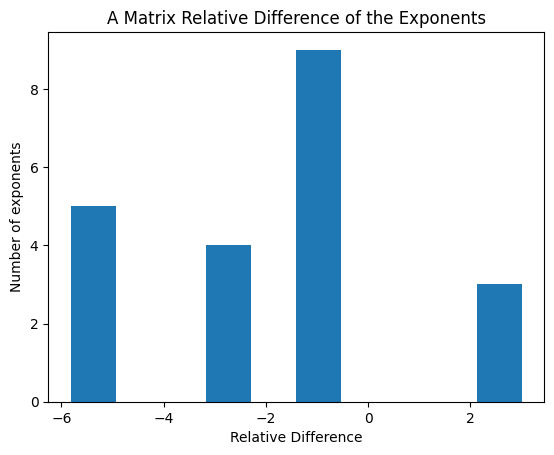

In [323]:
#calculate A matrix at t0


#position and velocity at t0
x = 6990077.798814194 #m
y = 1617465.311978378 #m
z = 22679.810569245355 #m
x_dot = -1675.13972506056 #m/s
y_dot = 7273.72441330686 #m/s
z_dot = 252.688512916741 #m/s

#gravity parameters

#drag parameters
A_Cross = 6 #[m^2]
C_D = 1.88

#third body parameters
r_sun = np.zeros((1, 3))
r_moon = np.zeros((1, 3))
r_sun[0] = sun_position_vector(JD_UTC, leap_sec, del_UT1)
r_moon[0] = moon_position_vector(JD_UTC, leap_sec, del_UT1)


#solar parameters
A_Cross_Sol = 15 #[m^2]



if gravity and drag and solar and third_body:
     A_1 = A(x, y, z, x_dot, y_dot, z_dot, C_D, A_Cross, A_Cross_Sol, r_sun, r_moon)

elif gravity:
     A_1 = A(x, y, z)

elif drag:
     A_1 = A(x, y, z, x_dot, y_dot, z_dot, C_D, A_Cross)

elif solar:
     A_1 = A(x, y, z, A_Cross_Sol)

elif third_body:
     A_1 = A(x, y, z, r_sun, r_moon)

else:
     A_1 = A(x, y, z)

A_1 = np.array(A_1)
A_0 = np.array([[0, 0, 0, 1, 0, 0, 0], \
                [0, 0, 0, 0, 1, 0, 0], \
                [0, 0, 0, 0, 0, 1, 0], \
                [1.9938487002181507e-06, 7.110891370508197e-07, 9.970765250251206e-09, 0, 0, 0, 0], \
                [7.110891370508197e-07, -9.146694803540985e-07, 2.3071798898857184e-09, 0, 0, 0, 0], \
                [9.970765250251206e-09, 2.3071798898857184e-09, -1.079179219864052e-06, 0, 0, 0, 0], \
                [0, 0, 0, 0, 0, 0, 0]])

A_true = np.array([[0,0,0,1,0,0,0],
               [0,0,0,0,1,0,0],
               [0,0,0,0,0,1,0],
               [1.9990475733644e-06,7.12612839542376e-07,1.00489067064843e-08,-2.65829597846294e-12,5.52635847842624e-13,2.06452887076393e-14,1.97068091243417e-12],
               [7.12613038229113e-07,-9.15703716126767e-07,2.32534862733938e-09,5.52635847842624e-13,-4.93156219616261e-12,-8.9677255203802e-14,-8.56007671349384e-12],
               [1.00489138810082e-08,2.32534964461914e-09,-1.08334385699352e-06,2.06452887076393e-14,-8.9677255203802e-14,-2.5344195911523e-12,-3.19786086623803e-13],
               [0,0,0,0,0,0,0]])

np.set_printoptions(precision=16)


relDiff = np.abs(np.divide((A_1[3:6] - A_true[3:6]), A_true[3:6]))
print('A Matrix Relative Difference \n', relDiff)
plt.hist(np.reshape(np.log10(relDiff), 3*7))
plt.title('A Matrix Relative Difference of the Exponents')
plt.xlabel('Relative Difference')
plt.ylabel('Number of exponents')

In [324]:
def a_third_body(r, r_sun, r_moon):
    x = r[0]
    y = r[1]
    z = r[2]
    mu_sun = 32712440018*1000**3 #m^3/s^2
    mu_moon = 4902.800066*1000**3 #m^3/s^2
    r_sun_mag = np.linalg.norm(r_sun)
    r_moon_mag = np.linalg.norm(r_moon)
    del_sun_mag = ((r_sun[0]+x)**2 + (r_sun[1]+y)**2 + (r_sun[2]+z)**2)**(1/2)
    del_moon_mag = ((r_moon[0]+x)**2 + (r_moon[1]+y)**2 + (r_moon[2]+z)**2)**(1/2)
    F_x = mu_sun*((r_sun[0]+x)/(del_sun_mag)**3 - r_sun[0]/r_sun_mag**3) + mu_moon*((r_moon[0]+x)/(del_moon_mag**3) - r_moon[0]/r_moon_mag**3)
    F_y = mu_sun*((r_sun[1]+y)/(del_sun_mag)**3 - r_sun[1]/r_sun_mag**3) + mu_moon*((r_moon[1]+y)/(del_moon_mag**3) - r_moon[1]/r_moon_mag**3)
    F_z = mu_sun*((r_sun[2]+z)/(del_sun_mag)**3 - r_sun[2]/r_sun_mag**3) + mu_moon*((r_moon[2]+z)/(del_moon_mag**3) - r_moon[2]/r_moon_mag**3)

    return np.array([F_x, F_y, F_z])



In [325]:
def a_solar(r, s, C_s, C_d, A_Cross_sol):
    
    
    r_ddot = np.zeros(3)
    tau_min = (np.linalg.norm(r)**2 - np.dot(r, s))/(np.linalg.norm(r)**2 + np.linalg.norm(s)**2 - 2*np.dot(r, s))
    
    if tau_min < 0:
        m = 2000 #kg
        c = 299792458 #m/s
        AU = 149597870.7*1000 #m
        d = np.linalg.norm(s+r)/AU #distance from sun
        phi = 1367 #W/m^2

        C1 = phi/c 
        v = 1/3*C_d
        mu = 1/2*C_s
        theta = 0

        B = 2*v*np.cos(theta)+4*mu*np.cos(theta)**2
        u = (s+r)/np.linalg.norm(s+r)

        r_ddot = (-C1/d**2*(B + (1-mu)*np.cos(theta))*A_Cross_sol/m)*u

    return r_ddot




In [326]:
def a_drag(C_D, r, v, A_Cross):

    '''
    Computes the acceleration due to atmospheric drag

    Inputs:
    r - position vector in ECI frame [m]
    v - velocity vector in ECI frame [m/s]
    A_Cross - cross sectional area of satellite [m^2]

    Outputs:
    F_drag - acceleration due to atmospheric drag [m/s^2]
    
    '''

    #drag parameters
    R_earth = 6378.1363*1000 #[m]
    m = 2000 #[kg]
    theta_dot = 7.292115146706979E-5 #[rad/s]
    rho_0 = 3.614E-13 #[kg/m^3]
    H = 88667.0 #[m]
    r0 = (700000.0 + R_earth) #[m]

    r_mag = np.linalg.norm(r)
    rho_A = rho_0*np.exp(-(r_mag-r0)/H)
    V_A_bar = np.array([v[0]+theta_dot*r[1], v[1]-theta_dot*r[0], v[2]])
    V_A = np.sqrt((v[0] + theta_dot*r[1])**2 +(v[1]-theta_dot*r[0])**2 + v[2]**2)


    return -1/2*C_D*A_Cross/m*rho_A*V_A*V_A_bar

In [327]:
def light_time_correction(JD_UTC, r_0, v_0, station):
    c = 299792458 #m/s
    ECI_station = ECEF2ECI(station, JD_UTC, leap_sec, x_p, y_p, del_UT1)
    rho_station = np.linalg.norm(r_0 - ECI_station)
    lt = rho_station/c
    tol = 1e-3 #m
    delta = 1
    old_X_lt = np.zeros(6)
    y0 = np.concatenate((r_0, v_0))
    new_X_lt = y0
    while delta > tol:
        old_X_lt = new_X_lt
        t = JD_UTC - lt/86400
        sol = solve_ivp(satellite_motion, [lt, 0], y0, args=(mu, JD_UTC), rtol=3E-14, atol=1E-16)
        
        new_station = ECEF2ECI(station, t, leap_sec, x_p, y_p, del_UT1)
        # print(new_station)
        new_X_lt = sol.y.T[-1]
        new_rho = np.linalg.norm(new_X_lt[0:3] - new_station)
        lt = new_rho/c
        delta = np.linalg.norm(new_X_lt[0:3] - old_X_lt[0:3])
        
    return new_X_lt


**H_Tilde Compute the relative difference for each non-zero element**

In [328]:
#H_tilde
def range_range_rate_H():
    x = sym.Symbol('x')
    y = sym.Symbol('y')
    z = sym.Symbol('z')
    x_dot = sym.Symbol('x_dot')
    y_dot = sym.Symbol('y_dot')
    z_dot = sym.Symbol('z_dot')

    x_s = sym.Symbol('x_s')
    y_s = sym.Symbol('y_s')
    z_s = sym.Symbol('z_s')
    
    rho = sym.sqrt((x - x_s)**2 + (y - y_s)**2 + (z - z_s)**2)
    #for project omega x r ECEF frame
    #vallado chapter 4 ECEF to ECI transformation
    omega_earth = np.array([0, 0, 7.292115146706979E-5]) #rad/s
    station_dot = np.cross(np.array([x_s, y_s, z_s]), omega_earth)
    rho_dot = ((x-x_s)*(x_dot-station_dot[0]) + (y-y_s)*(y_dot-station_dot[1]) + (z-z_s)*(z_dot-station_dot[2]))/rho
    return rho, rho_dot

ECIstations = [ECEF2ECI(station, JD_UTC, leap_sec, x_p, y_p, del_UT1) for station in stations]
station = stations[np.argmin(np.linalg.norm(r_0 - ECIstations, axis = 1))]
ECIstation = ECIstations[np.argmin(np.linalg.norm(r_0 - ECIstations, axis = 1))]
rho_1, drho_1 = range_range_rate_H()


x = sym.Symbol('x')
y = sym.Symbol('y')
z = sym.Symbol('z')
x_dot = sym.Symbol('x_dot')
y_dot = sym.Symbol('y_dot')
z_dot = sym.Symbol('z_dot')
x_s = sym.Symbol('x_s')
y_s = sym.Symbol('y_s')
z_s = sym.Symbol('z_s')
C_D = sym.Symbol('C_D')

H_tilde_sym = [[sym.diff(rho_1, x), sym.diff(rho_1, y), sym.diff(rho_1, z), sym.diff(rho_1, x_dot), sym.diff(rho_1, y_dot), sym.diff(rho_1, z_dot), sym.diff(rho_1, C_D)],[
           sym.diff(drho_1, x), sym.diff(drho_1, y), sym.diff(drho_1, z), sym.diff(drho_1, x_dot), sym.diff(drho_1, y_dot), sym.diff(drho_1, z_dot), sym.diff(drho_1, C_D)]]


r_lt  = light_time_correction(JD_UTC, r_ECI, v_ECI, station)
H_tilde_func = sym.lambdify((x, y, z, x_dot, y_dot, z_dot, x_s, y_s, z_s, C_D), H_tilde_sym, 'numpy')
H_tilde = H_tilde_func(r_lt[0], r_lt[1], r_lt[2], r_lt[3], r_lt[4], r_lt[5], ECIstation[0], ECIstation[1], ECIstation[2], 1.88)
H_tilde_true = np.array([[0.653470716486393,0.102498573784402,-0.749980043112431,0,0,0,0],
[-0.000923151547374937,0.00515759358602085,-9.94780021776166e-05,0.653470716486393,0.102498573784402,-0.749980043112431,0]])
np.set_printoptions(precision=8, suppress=True)
reldiff = np.divide(np.abs(H_tilde - H_tilde_true), H_tilde_true)
print("Relative Difference of H_tilde\n",  reldiff)

Relative Difference of H_tilde
 [[ 0.00051824  0.00007988 -0.00039512         nan         nan         nan
          nan]
 [-0.14932968  0.13122039 -0.28233085  0.00051824  0.00007988 -0.00039512
          nan]]


**2. Integrate position, velocity, and Φ(ti,t0) from t = 0,...,21600 seconds. Store the results in 60
second intervals.**

In [329]:
def satellite_motion_phi(t, R, mu, A, JD_UTC):
    J_2 = 0.00108248
    phi = R[6:].reshape(7, 7)
    R_earth = 6378.1363*1000 # m
    r = R[0:3]
    r_dot = R[3:6]
    x, y, z = R[0:3]
    x_dot, y_dot, z_dot = R[3:6]
    JD_UTC += t/86400

    #J2
    dUdx = -1.0*mu*x*(-J_2*R_earth**2*(1.5*z**2/(x**2 + y**2 + z**2)**1.0 - 0.5)/(x**2 + y**2 + z**2)**1.0 + 1)/(x**2 + y**2 + z**2)**1.5 \
        + mu*(3.0*J_2*R_earth**2*x*z**2/(x**2 + y**2 + z**2)**3.0 + 2.0*J_2*R_earth**2*x*(1.5*z**2/(x**2 + y**2 + z**2)**1.0 - 0.5)/(x**2 \
        + y**2 + z**2)**2.0)/(x**2 + y**2 + z**2)**0.5
    dUdy = -1.0*mu*y*(-J_2*R_earth**2*(1.5*z**2/(x**2 + y**2 + z**2)**1.0 - 0.5)/(x**2 + y**2 + z**2)**1.0 + 1)/(x**2 + y**2 + z**2)**1.5 \
        + mu*(3.0*J_2*R_earth**2*y*z**2/(x**2 + y**2 + z**2)**3.0 + 2.0*J_2*R_earth**2*y*(1.5*z**2/(x**2 + y**2 + z**2)**1.0 - 0.5)/(x**2 \
        + y**2 + z**2)**2.0)/(x**2 + y**2 + z**2)**0.5
    dUdz = -1.0*mu*z*(-J_2*R_earth**2*(1.5*z**2/(x**2 + y**2 + z**2)**1.0 - 0.5)/(x**2 + y**2 + z**2)**1.0 + 1)/(x**2 + y**2 + z**2)**1.5\
        + mu*(2.0*J_2*R_earth**2*z*(1.5*z**2/(x**2 + y**2 + z**2)**1.0 - 0.5)/(x**2 + y**2 + z**2)**2.0 - J_2*R_earth**2*(-3.0*z**3/(x**2 \
            + y**2 + z**2)**2.0 + 3.0*z/(x**2 + y**2 + z**2)**1.0)/(x**2 + y**2 + z**2)**1.0)/(x**2 + y**2 + z**2)**0.5
    
    #drag
    A_Cross = 6
    C_D = 1.88
    r_ddot_drag = a_drag(C_D, r, r_dot, A_Cross)

    #solar
    leap_sec = 37
    del_UT1 = 196.5014 #[s]
    r_sun = np.zeros((1, 3))
    r_sun[0] = sun_position_vector(JD_UTC, leap_sec, del_UT1)
    C_s = 0.04
    C_d = 0.04
    A_Cross_sol = 15
    r_ddot_sol = a_solar(r, r_sun[0], C_s, C_d, A_Cross_sol)
    

    #third body
    r_moon = np.zeros((1, 3))
    r_moon[0] = moon_position_vector(JD_UTC, leap_sec, del_UT1)
    r_ddot_tb = a_third_body(r, r_sun[0], r_moon[0])


    #total acceleration
    r_ddot = np.array([dUdx, dUdy, dUdz]) + r_ddot_drag  + r_ddot_sol + r_ddot_tb
    
    #A matrix
    A_1 = np.array(A(x, y, z, x_dot, y_dot, z_dot, C_D, A_Cross, A_Cross_Sol, r_sun, r_moon))
    
    #state transition matrix
    phi_dot = np.matmul(A_1, phi)
   
    dydt = np.concatenate((r_dot, r_ddot, phi_dot.ravel()))
    
    return dydt

In [330]:
#initial Conditions
t = np.arange(0, 21660, 60)

phi = np.eye(7)

y0 = np.concatenate([r_ECI, v_ECI, phi.ravel()])

#numeric integration
sol_phi = solve_ivp(satellite_motion_phi, [0, 21660], y0, args=(mu, A, JD_UTC), t_eval=t, rtol=3E-14, atol=1E-16)

**Compare your results with those on the web (found on ther Canvas site) and
compute the relative difference of the top left relevant portion of Φ(21600,0)**

Phi Relative Difference
 [[  0.00082123   0.00076764   0.00301632   0.00093838   0.00084332
    0.00025573 997.59547833]
 [  0.0002074    0.00022688   0.00180474   0.00009687   0.00016424
    0.00080466 998.45974928]
 [  0.00104381   0.00090452   0.00031013   0.00117131   0.00096582
    0.00193084 999.5220847 ]
 [  0.00011458   0.00018432   0.002289     0.0000584    0.00006766
    0.00069487 998.38235847]
 [  0.00087415   0.00083655   0.00305884   0.00105647   0.0009468
    0.00028073 997.22598981]
 [  0.00112638   0.00113603   0.00136418   0.00128512   0.00123489
    0.00015151 996.91082525]]


Text(0, 0.5, 'Number of exponents')

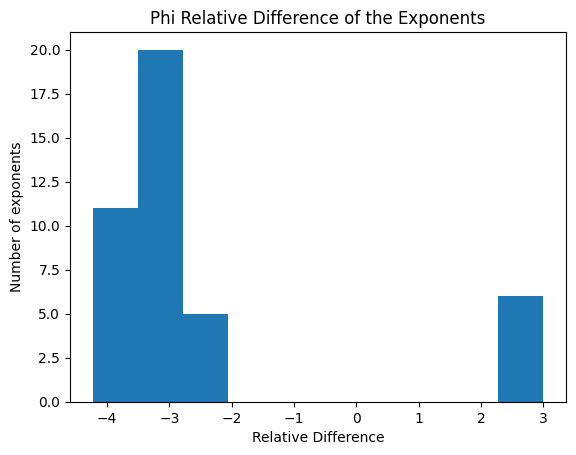

In [331]:

phi_true = np.array([-39.3390954700328,-10.4838421164098,-0.178515806381632,7255.51749588224,-39670.7241027289,-1372.29198687773,0.0030445773158455,
52.8126590572353,14.8760562610219,0.293617329755136,-8643.59756483467,52182.3557002297,1811.8195497131,-0.00391612715718706,
1.92398345007054,0.572231449979784,-0.916857134048049,-320.223120784111,1920.54246971582,-303.785573374237,-0.000143323034520295,
-0.0574389810576982,-0.0148097800062921,-0.00023756274651235,10.8032803603046,-56.9190551092895,-1.9721591633074,4.34741301050209e-06,
-0.0361975224561024,-0.0098256188572871,-0.000180772521863657,6.09947887593858,-35.0199347490215,-1.17782026574266,2.70486338281634e-06,
-0.00101917635090016,-0.000293484527003083,0.000395824353451442,0.163846785698186,-0.952008640270825,-0.951074388701294,7.62686157098573e-08,
0,0,0,0,0,0,1]).reshape(7,7)


phi = sol_phi.y.T[-1][6:].reshape(7,7)
relDiffPhi = abs(np.divide((phi[:6] - phi_true[:6]), phi_true[:6]))
print('Phi Relative Difference\n', relDiffPhi)
plt.hist(np.reshape(np.log10(abs(relDiffPhi)), relDiffPhi.shape[0]*relDiffPhi.shape[1]))
plt.title('Phi Relative Difference of the Exponents')
plt.xlabel('Relative Difference')
plt.ylabel('Number of exponents')

**Calculate the predicted range and range-rate for the appropriate tracking station at each observa-
tion time (use the data provided on the Canvas site).**

In [332]:
def range_range_rate(r, v, station):
    
    omega_earth = np.array([0, 0, 7.292115146706979E-5]) #rad/s
    station_dot = np.cross(station, omega_earth)
    rho = np.linalg.norm(r - station)
    rho_dot = np.dot(r - station, v - station_dot)/rho
    return rho, rho_dot


In [333]:
#read in LEO_DATA_APPARENT.csv
leo_app = "LEO_DATA_Apparent.csv"

#observations column names
column_names = ['id', 'time', 'range', 'range_rate']

#observations dataframe
obs_df = pd.read_csv(leo_app, names=column_names)

In [334]:
with open('range_rate.csv', 'w') as csvfile:
    writer = csv.writer(csvfile, delimiter=',',
                            quotechar='|', quoting=csv.QUOTE_MINIMAL)
    for i in range(0, len(obs_df)):
        r_ECI = sol_phi.y.T[int(obs_df['time'][i]/60)][0:3]
        v_ECI = sol_phi.y.T[int(obs_df['time'][i]/60)][3:6]
        JD_UTC_i = JD_UTC + obs_df['time'][i]/86400
        
        station_index = obs_df['id'][i]-1
        station = stations[station_index]
        ECIstation = ECEF2ECI(station, JD_UTC_i, leap_sec, x_p, y_p, del_UT1)

        r_lt = light_time_correction(JD_UTC_i, r_ECI, v_ECI, station)
        rho, rho_dot = range_range_rate(r_lt[0:3], r_lt[3:6], ECIstation)
        writer.writerow([station_index+1, i*60, rho/1000, rho_dot/1000])


**Calculate the range residual RMS and range-rate residual RMS**

In [335]:
#prefit RMS
df_calc = pd.read_csv('range_rate.csv', names=column_names)


r_calc_Atoll = df_calc['range'][df_calc.index[df_calc['id']==1]]
rr_calc_Atoll = df_calc['range_rate'][df_calc.index[df_calc['id']==1]]
r_calc_Diego = df_calc['range'][df_calc.index[df_calc['id']==2]]
rr_calc_Diego = df_calc['range_rate'][df_calc.index[df_calc['id']==2]]
r_calc_Arecibo = df_calc['range'][df_calc.index[df_calc['id']==3]]
rr_calc_Arecibo = df_calc['range_rate'][df_calc.index[df_calc['id']==3]]

r_obs_Atoll = obs_df['range'][obs_df.index[obs_df['id']==1]]
rr_obs_Atoll = obs_df['range_rate'][obs_df.index[obs_df['id']==1]]
r_obs_Diego = obs_df['range'][obs_df.index[obs_df['id']==2]]
rr_obs_Diego = obs_df['range_rate'][obs_df.index[obs_df['id']==2]]
r_obs_Arecibo = obs_df['range'][obs_df.index[obs_df['id']==3]]
rr_obs_Arecibo = obs_df['range_rate'][obs_df.index[obs_df['id']==3]]

RMS_Atoll_r = np.sqrt(np.mean((r_obs_Atoll - r_calc_Atoll)**2))
RMS_Diego_r = np.sqrt(np.mean((r_obs_Diego - r_calc_Diego)**2))
RMS_Arecibo_r = np.sqrt(np.mean((r_obs_Arecibo - r_calc_Arecibo)**2))

RMS_Atoll_rr = np.sqrt(np.mean((rr_obs_Atoll - rr_calc_Atoll)**2))
RMS_Diego_rr = np.sqrt(np.mean((rr_obs_Diego - rr_calc_Diego)**2))
RMS_Arecibo_rr = np.sqrt(np.mean((rr_obs_Arecibo - rr_calc_Arecibo)**2))


print("Atoll Range RMS:", RMS_Atoll_r, "[km]", "Diego Range RMS:", RMS_Diego_r, "[km]", "Arecibo Range RMS:",  RMS_Arecibo_r,"[km]")
print("Atoll Range Rate RMS:", RMS_Atoll_rr,"[km/s]", "Diego Range Rate RMS:", RMS_Diego_rr, "[km/s]", "Arecibo Range Rate RMS:",  RMS_Arecibo_rr, "[km/s]")

Atoll Range RMS: 426.8463079508304 [km] Diego Range RMS: 474.8282450627112 [km] Arecibo Range RMS: 245.59363226095888 [km]
Atoll Range Rate RMS: 2.00394512497117 [km/s] Diego Range Rate RMS: 2.2118040506919194 [km/s] Arecibo Range Rate RMS: 1.4921202314958577 [km/s]


**Compare and plot the range and range-rate residuals (post-fit).**

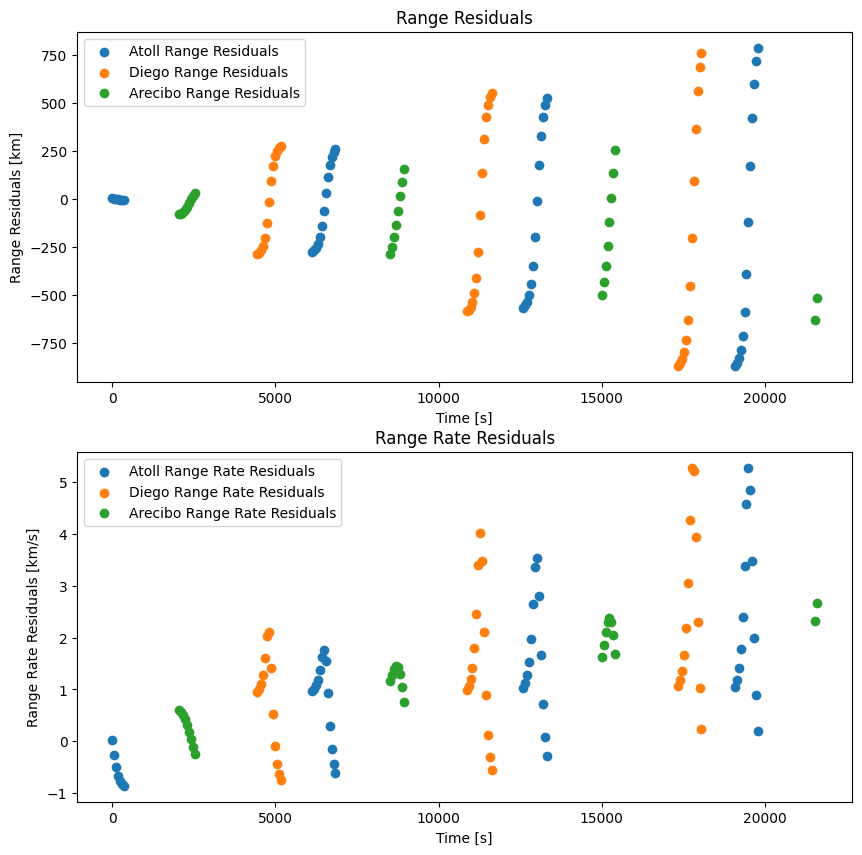

In [336]:
#Comparing Pre-fit residuals
fig, ax = plt.subplots(2, 1, figsize=(10, 10))
t_atoll = obs_df['time'][obs_df.index[obs_df['id']==1]]
t_diego = obs_df['time'][obs_df.index[obs_df['id']==2]]
t_arecibo = obs_df['time'][obs_df.index[obs_df['id']==3]]

ax[0].scatter(t_atoll, r_obs_Atoll - r_calc_Atoll, label='Atoll Range Residuals')
ax[0].scatter(t_diego, r_obs_Diego - r_calc_Diego, label='Diego Range Residuals')
ax[0].scatter(t_arecibo, r_obs_Arecibo - r_calc_Arecibo, label='Arecibo Range Residuals')
ax[0].set_title('Range Residuals')
ax[0].set_xlabel('Time [s]')
ax[0].set_ylabel('Range Residuals [km]')
ax[0].legend()

ax[1].scatter(t_atoll, rr_obs_Atoll - rr_calc_Atoll, label='Atoll Range Rate Residuals')
ax[1].scatter(t_diego, rr_obs_Diego - rr_calc_Diego, label='Diego Range Rate Residuals')
ax[1].scatter(t_arecibo, rr_obs_Arecibo - rr_calc_Arecibo, label='Arecibo Range Rate Residuals')
ax[1].set_title('Range Rate Residuals')
ax[1].set_xlabel('Time [s]')
ax[1].set_ylabel('Range Rate Residuals [km/s]')
ax[1].legend()
